**Car Price Prediction**

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv(r'car_price_dataset.csv')

df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [52]:
df.shape

(10000, 10)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [54]:
df.duplicated().sum()

0

In [55]:

num_cols = ['Year', 'Engine_Size'  ,'Mileage' , 'Price']
cat_cols = ['Brand' , 'Model' , 'Doors' , 'Owner_Count' , 'Fuel_Type' , 'Transmission']

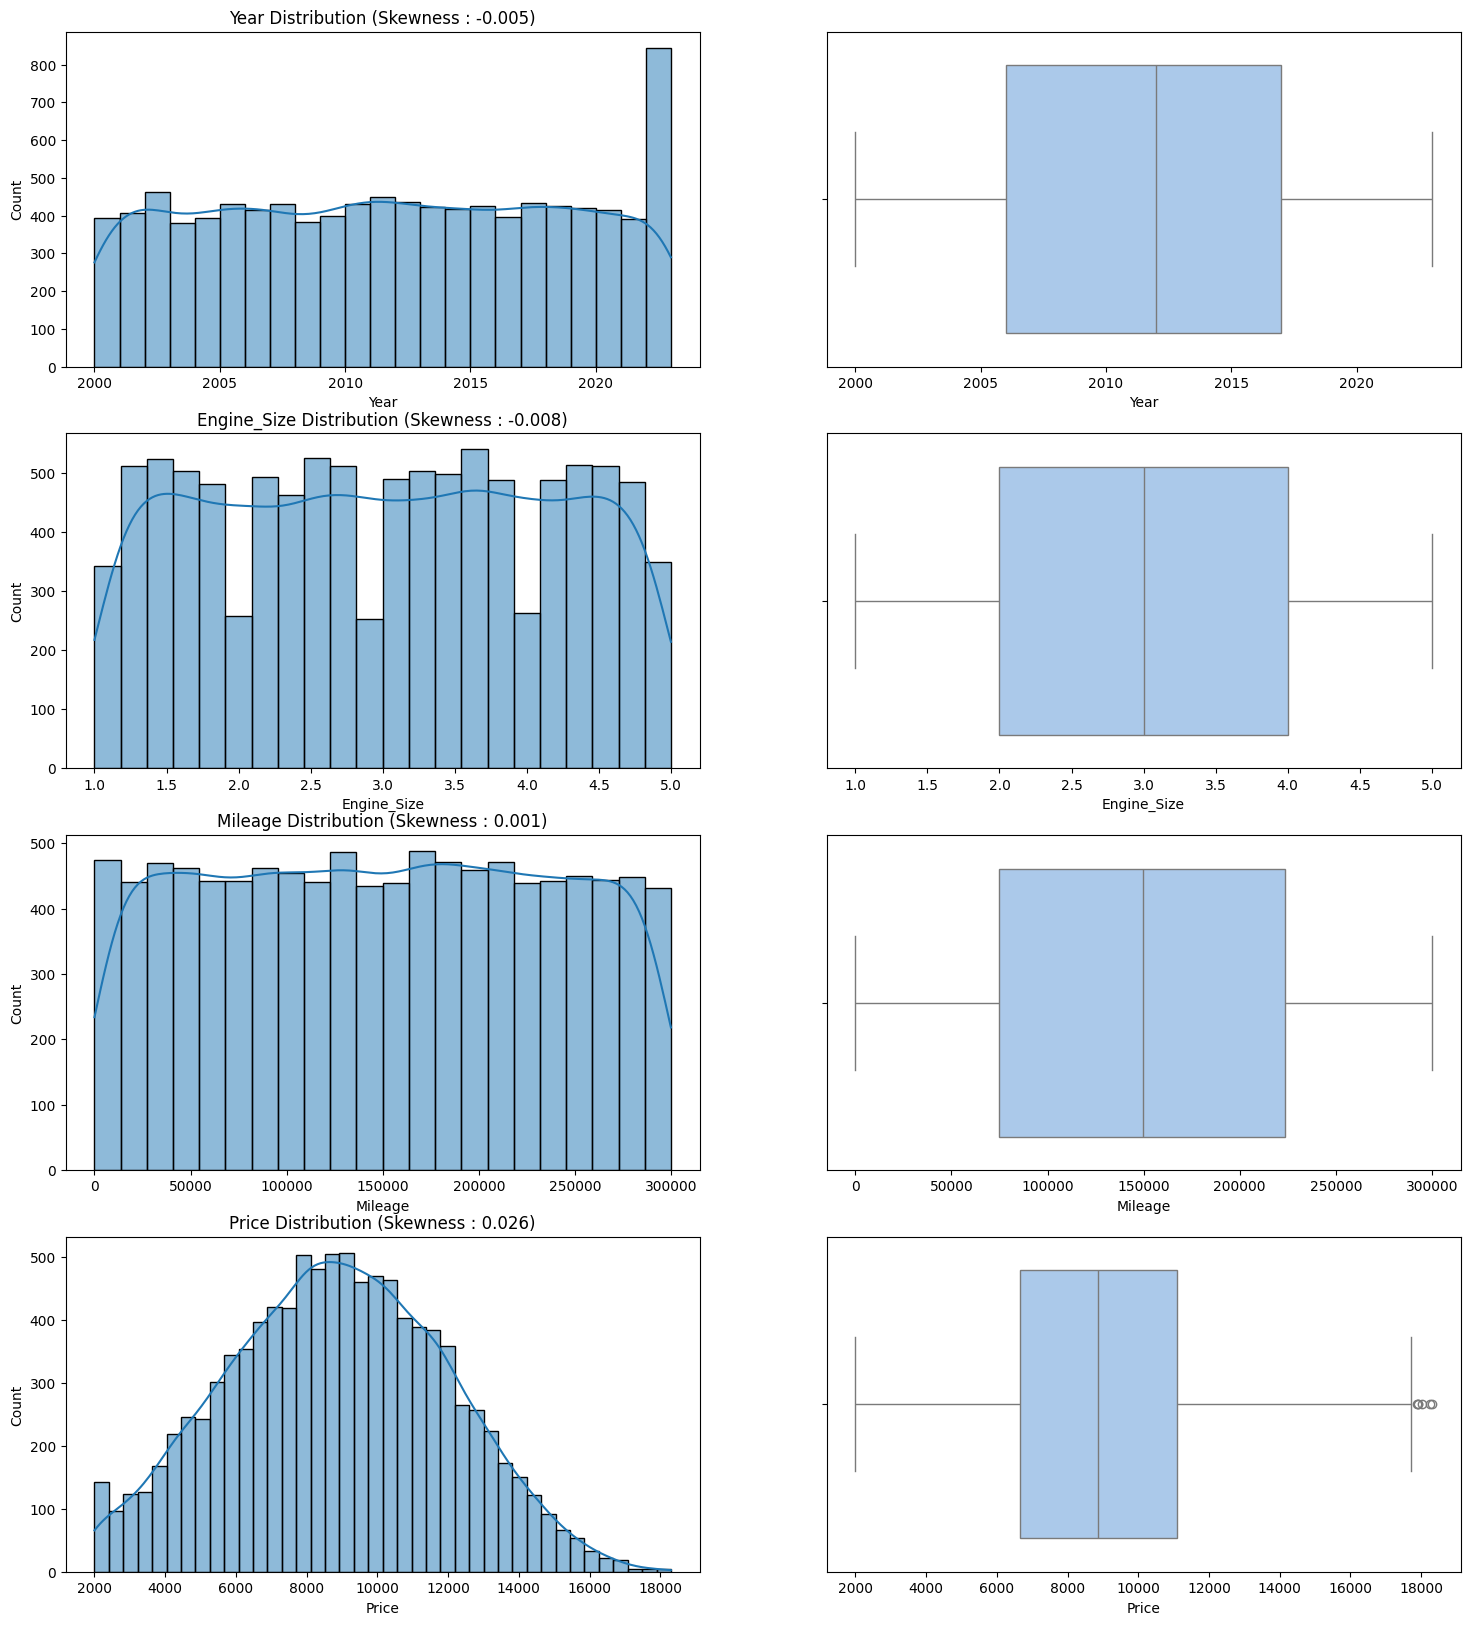

In [56]:
plt.figure(figsize=(18 , len(num_cols)*5))
for i,col in enumerate(num_cols):
    ax1 = plt.subplot(len(num_cols),2,2*i + 1)
    sns.histplot(df[col] , kde=True)
    ax1.set_title(f"{col} Distribution (Skewness : {round(df[col].skew() , 3)})")
    ax2 = plt.subplot(len(num_cols) , 2 , 2*i+2)
    sns.boxplot(data =df , x =col , palette='pastel')
plt.show()

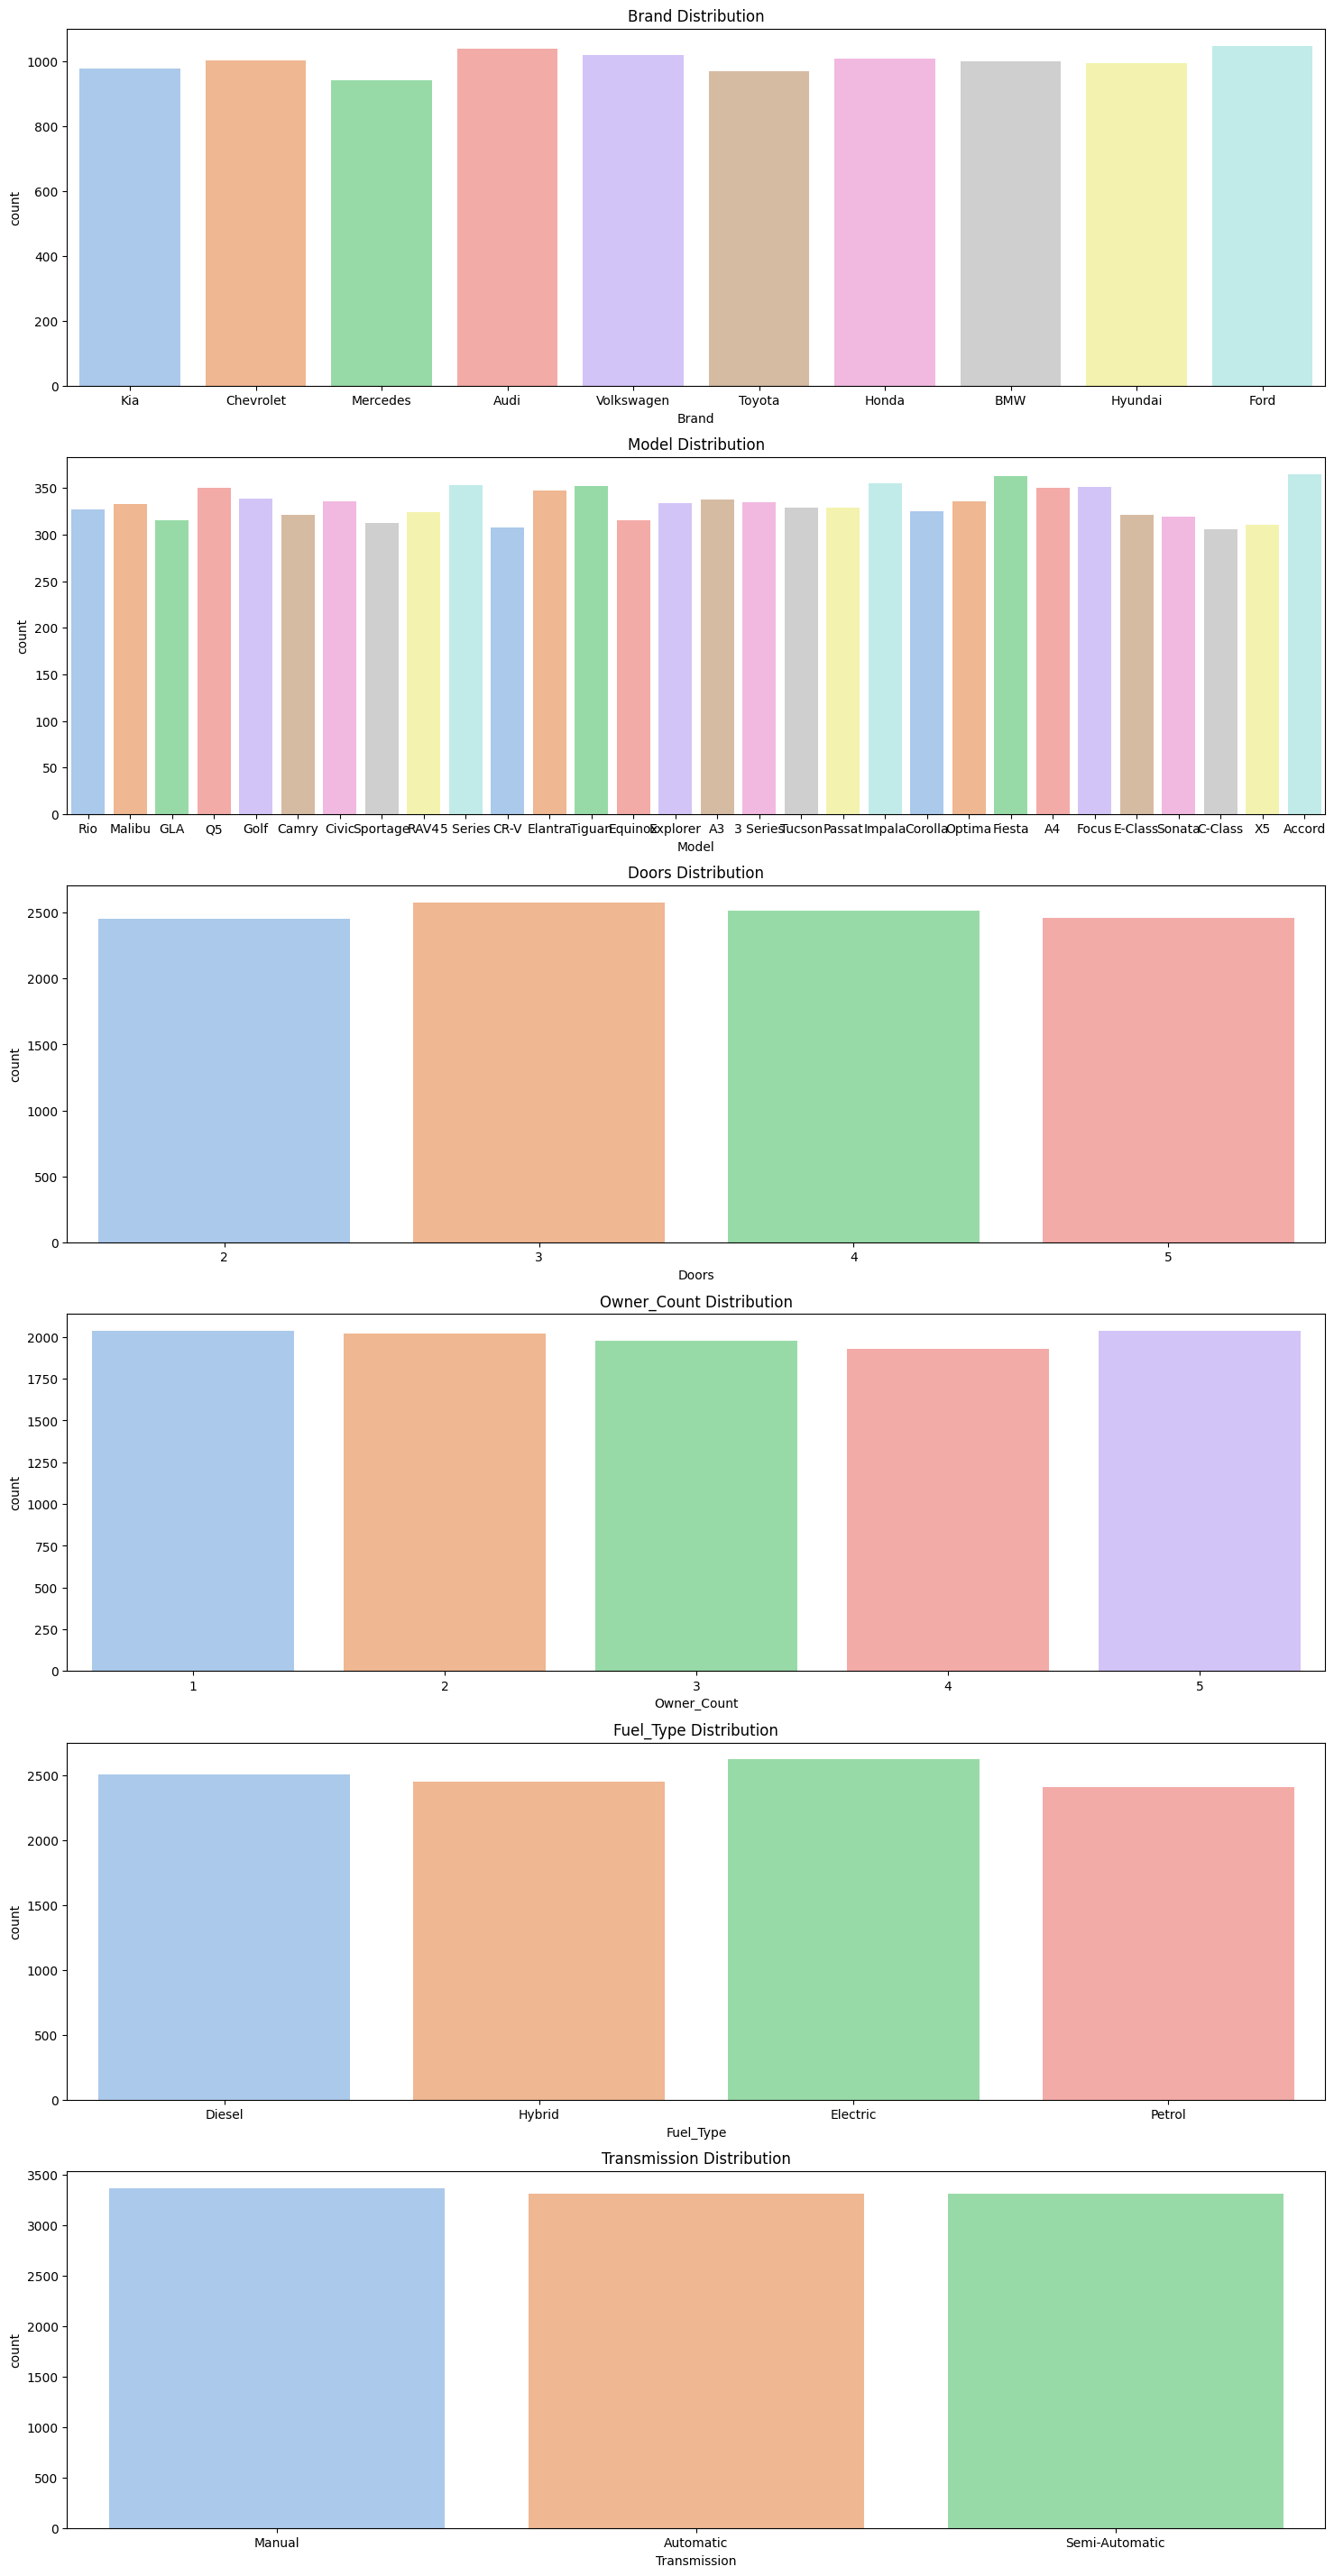

In [57]:
plt.figure(figsize=(18 , len(cat_cols)*len(cat_cols)))
for i,col in enumerate(cat_cols):
    ax = plt.subplot(len(cat_cols),1,i+1)
    sns.countplot(data=df , x=col ,palette='pastel')
    ax.set_title(f"{col} Distribution")
plt.show()

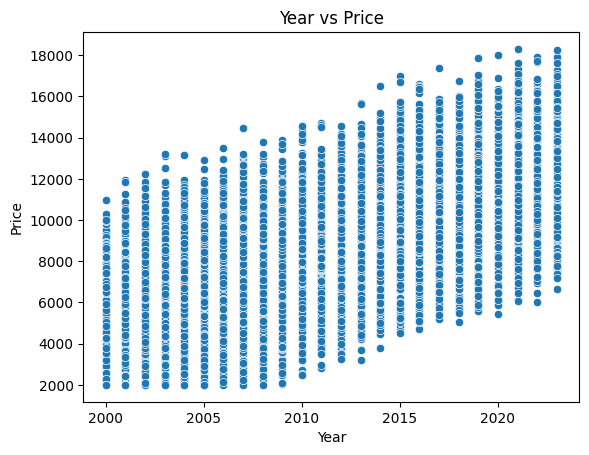

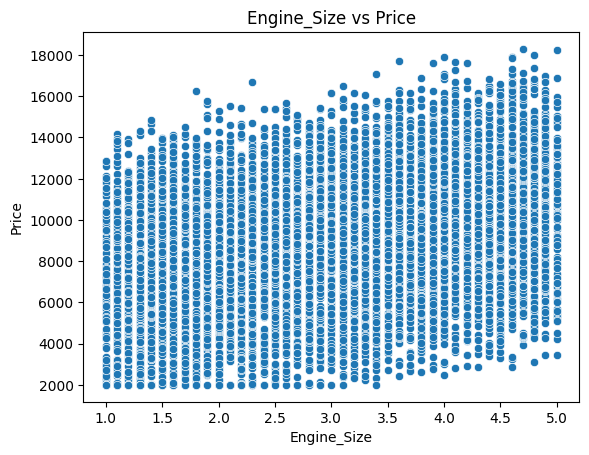

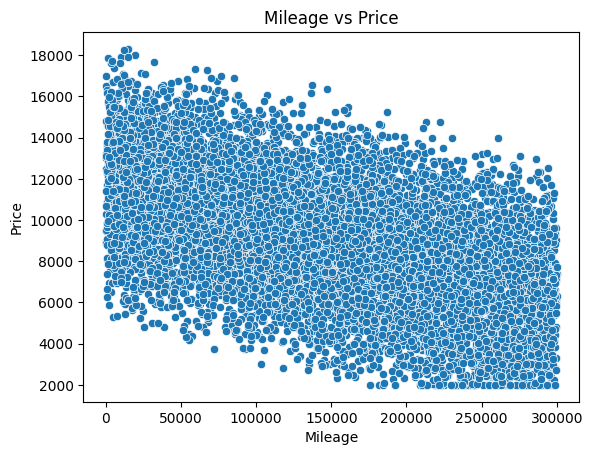

In [58]:
for col in num_cols :
    if col=='Price' : continue
    sns.scatterplot(data=df , x=col , y="Price")
    plt.title(f'{col} vs Price')
    plt.show()


<Axes: >

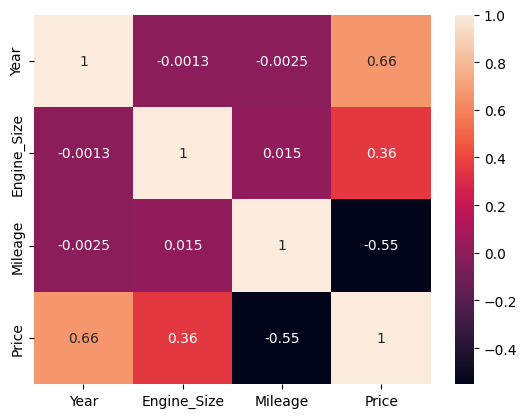

In [59]:
corr = df[num_cols].corr()
sns.heatmap(corr ,annot=True)

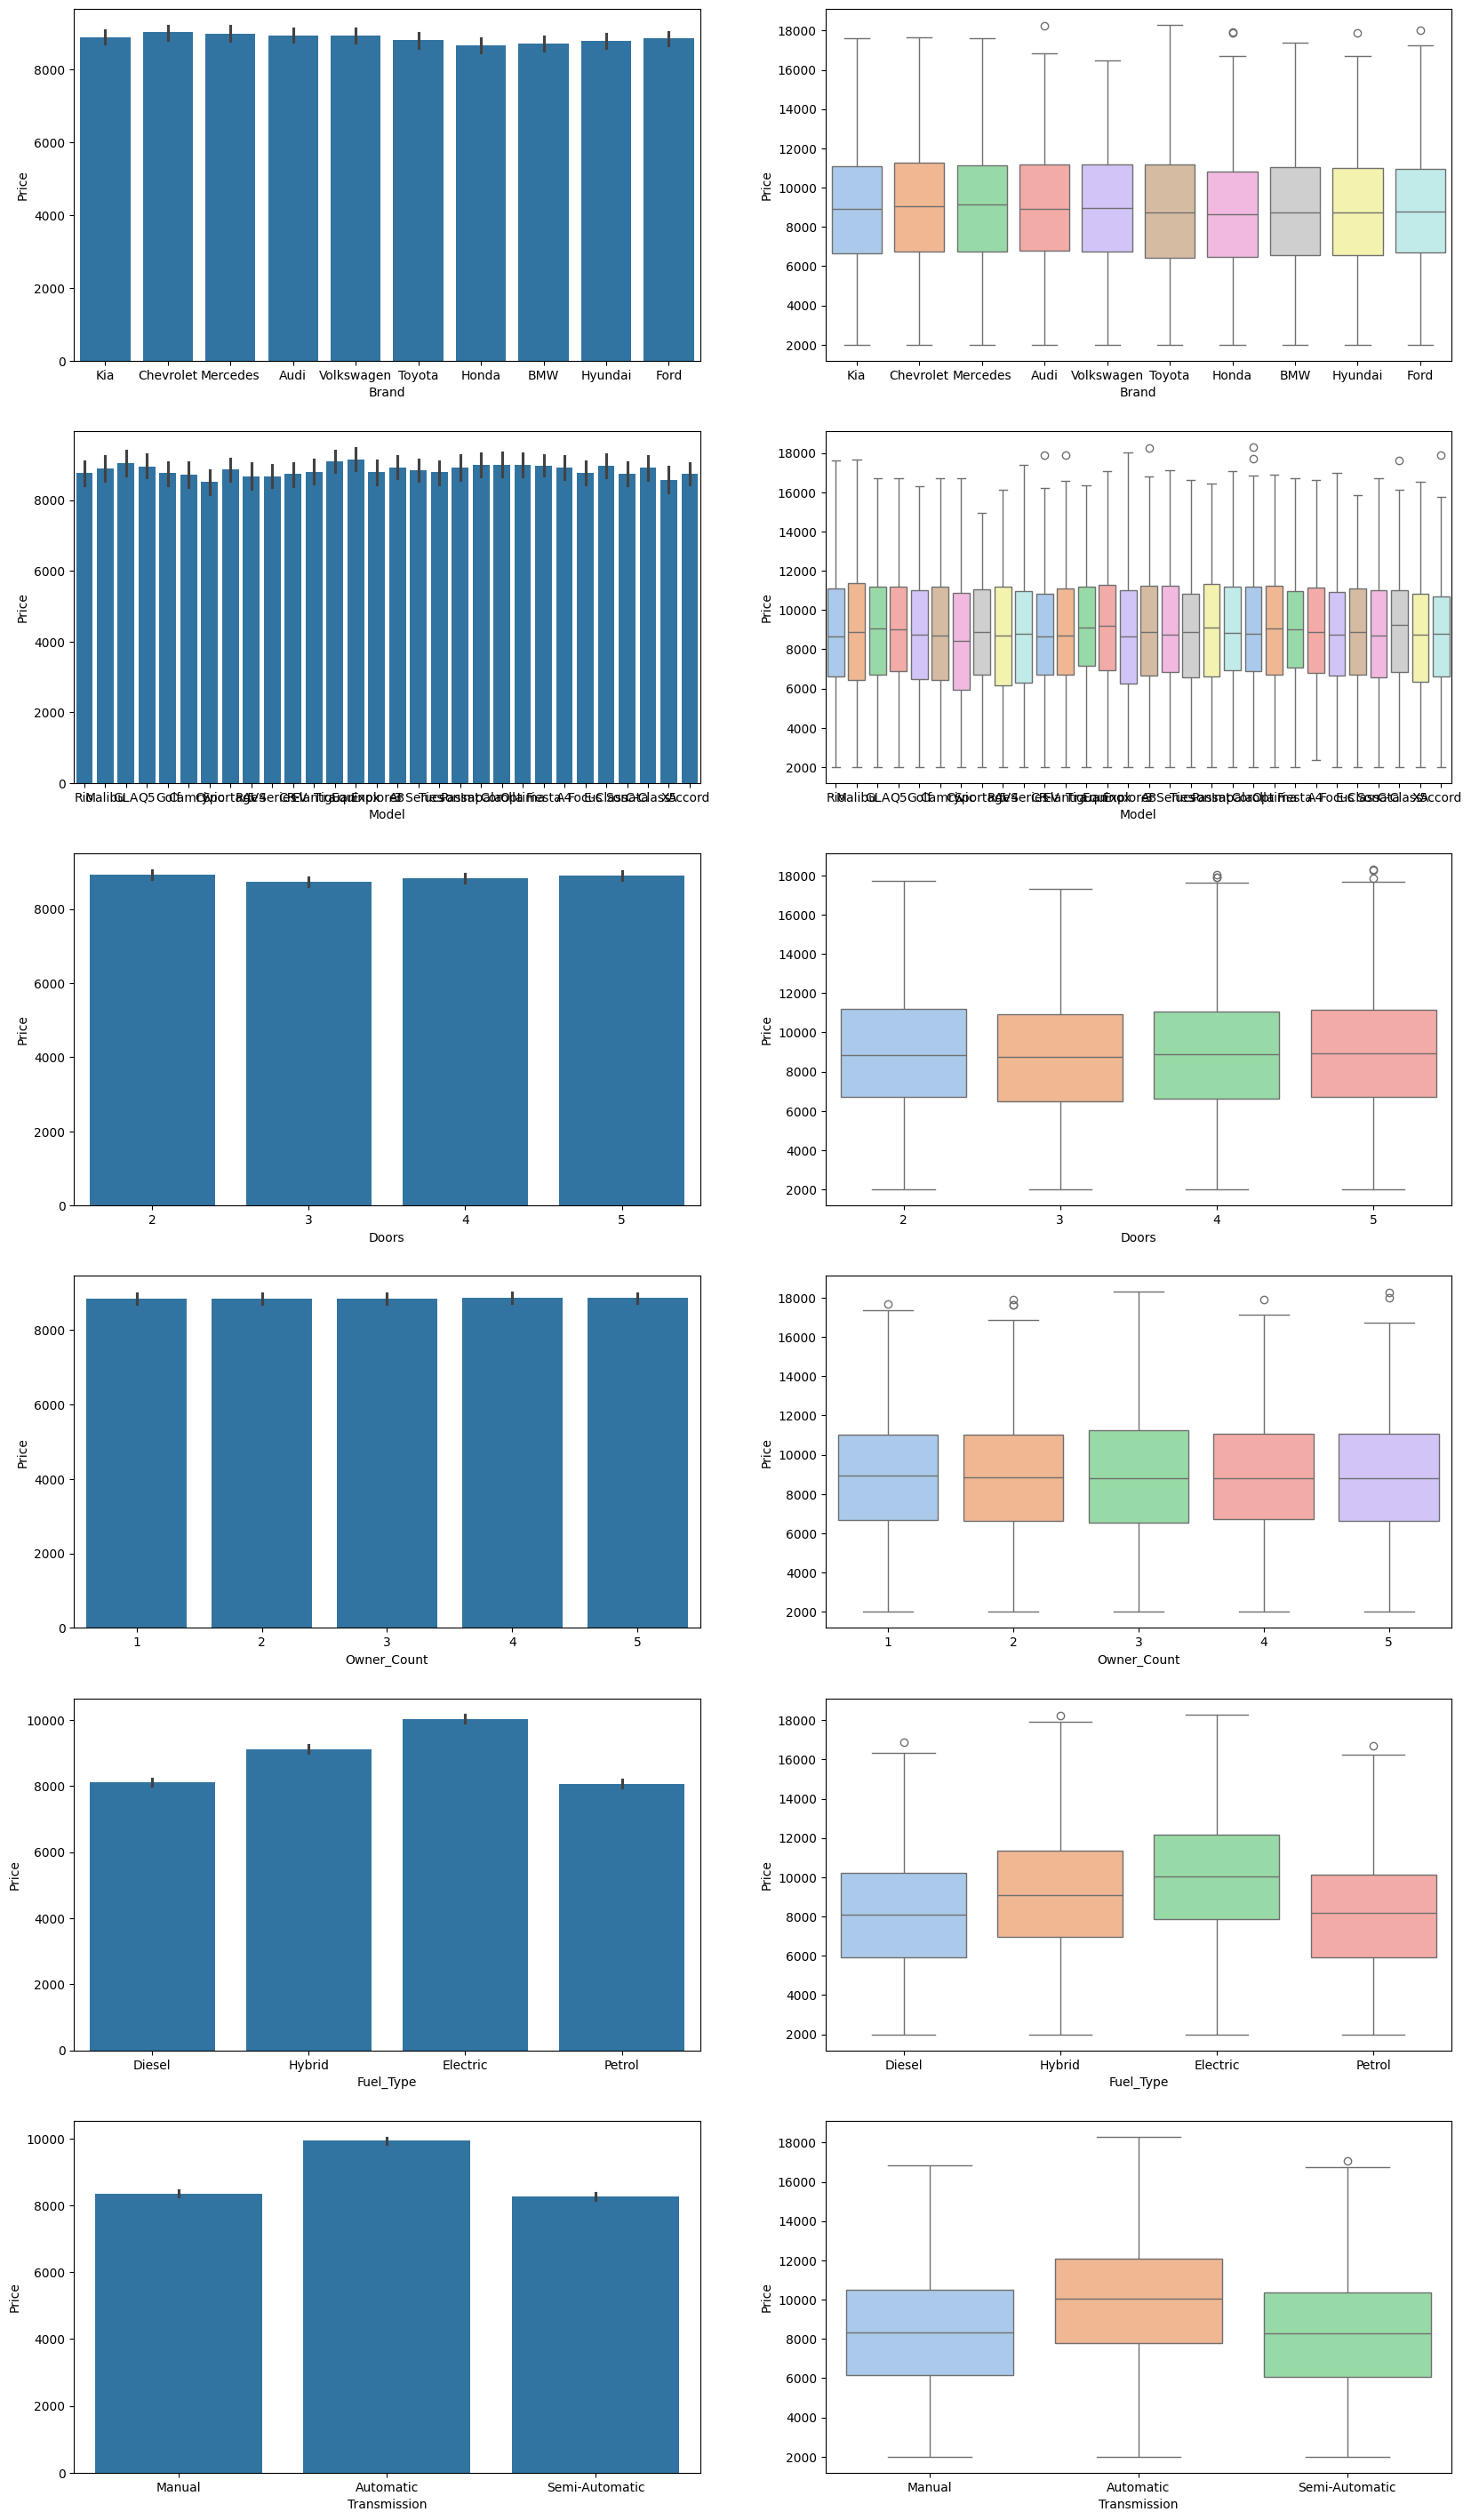

In [60]:
plt.figure(figsize=(20 , len(cat_cols)*len(cat_cols)))
for i,col in enumerate(cat_cols):
    plt.subplot(len(cat_cols),2,2*i + 1)
    sns.barplot(data=df , x=col , y="Price")
    plt.subplot(len(cat_cols) , 2 , 2*i+2)
    sns.boxplot(data =df , x =col , y='Price', palette='pastel')
plt.show()

<Axes: xlabel='Fuel_Type', ylabel='Price'>

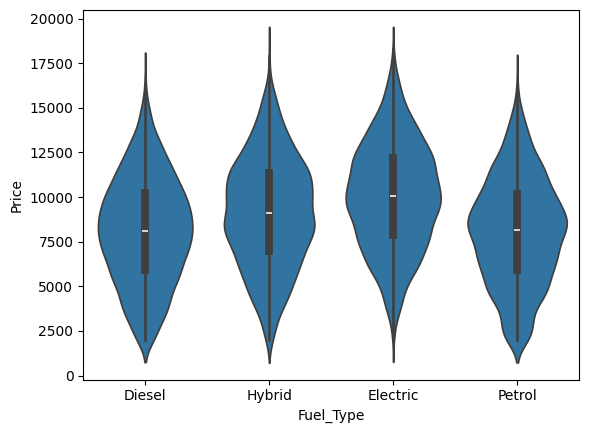

In [61]:
sns.violinplot(x='Fuel_Type', y='Price', data=df)

In [62]:
df.groupby('Fuel_Type')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel_Type,,,,,,,,
Diesel,2512.0,8117.336385,2979.033575,2000.0,5940.0,8107.0,10222.25,16854.0
Electric,2625.0,10032.220190,2988.575806,2000.0,7881.0,10051.0,12177.00,18301.0
Hybrid,2453.0,9113.030167,3055.538900,2000.0,6955.0,9110.0,11343.00,18255.0
Petrol,2410.0,8070.561826,2994.982789,2000.0,5910.5,8167.5,10148.75,16717.0


In [63]:
def process(data):
    data['Car'] = data['Brand'] + " " + data['Model']
    data['Fuel_Type'] = df['Fuel_Type'].map({"Electric":4 , "Hybrid":3 ,"Diesel":2 ,"Petrol":1 })
    data['Transmission'] = df['Transmission'].map({"Automatic":3 , "Semi-Automatic":2 , "Manual":1})
    data['Year'] = (data['Year'] - 2000)
    data.drop(columns=['Owner_Count' , 'Doors','Brand' , "Model"] , axis=1 , inplace=True)
    data = pd.get_dummies(data, columns=['Car'], drop_first=True)
    return data

In [64]:
from sklearn.model_selection import train_test_split

df = process(df)
y = df['Price']
X = df.drop(columns=['Price'] , axis=1)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size =0.3 , random_state=42)

In [65]:
from sklearn.preprocessing import MinMaxScaler

se = MinMaxScaler()
num_cols = ['Mileage' , 'Engine_Size','Year']
se.fit(X_train[num_cols])

X_train[num_cols] = se.transform(X_train[num_cols])
X_test[num_cols] = se.transform(X_test[num_cols])

In [66]:
from sklearn.metrics import mean_squared_error , r2_score

def train(models):
    res = pd.DataFrame(columns=['RMSE' , "R2"])
    for model in models:
        model.fit(X_train , y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test ,y_pred , squared=False)
        r2 = r2_score(y_test ,y_pred)
        model_name = model.__class__.__name__
        res.loc[model_name] = [rmse , r2]
    return res

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def train(models):
    res = pd.DataFrame(columns=['RMSE', "R2"])
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        model_name = model.__class__.__name__
        res.loc[model_name] = [rmse, r2]
    return res

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]


res = train(models)
res

,RMSE,R2
LinearRegression,448.177616,0.978639
DecisionTreeRegressor,597.156838,0.962077
RandomForestRegressor,290.228050,0.991042


In [68]:
res

,RMSE,R2
LinearRegression,448.177616,0.978639
DecisionTreeRegressor,597.156838,0.962077
RandomForestRegressor,290.228050,0.991042


In [69]:
best_params = {'iterations': 1776,
               'learning_rate': 0.09347252968107714,
               'depth': 7,
               'l2_leaf_reg': 1.0108118442861742}

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor


model = CatBoostRegressor(**best_params, logging_level="Silent")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best Model is CatBoostRegressor with RMSE: {rmse} R2:{r2*100}")

Best Model is CatBoostRegressor with RMSE: 32.165972032885755 R2:99.98899678049068


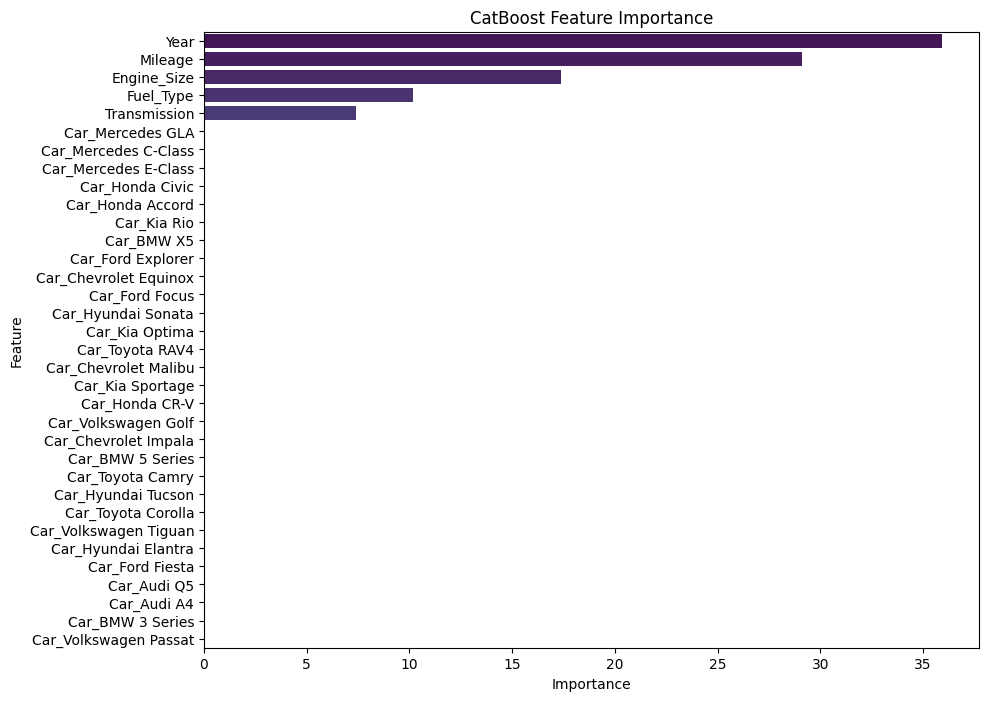

In [73]:
feature_importance = model.get_feature_importance()
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
